In [1]:
import time
import json

import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_squared_error, accuracy_score, plot_confusion_matrix, f1_score
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix

import stellargraph as sg
from stellargraph import datasets
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    Node2VecNodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE, Dense

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model, optimizers, losses, metrics

from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE, KMeansSMOTE, SMOTENC, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.metrics import classification_report_imbalanced

from collections import Counter, defaultdict
import multiprocessing
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
import sys
sys.path.append('../')
import utils

In [3]:
v_sets, e_sets, core_targets, ext_targets, core_testing = utils.load_for_jupyter_raw()

Dataset already downloaded. Loading it from file system
LOADING DATA: 0.95 s


In [4]:
v_sample = v_sets
e_sample = e_sets

In [5]:
v_sample.CoreCaseGraphID = v_sample.CoreCaseGraphID.fillna(0)
v_sample.ExtendedCaseGraphID = v_sample.ExtendedCaseGraphID.fillna(0)
v_sets = defaultdict()
for v_type in list(pd.Categorical(v_sample.Label).categories):
    v_sets[v_type] = v_sample[v_sample.Label == v_type]
    v_sets[v_type] = v_sets[v_type].drop(['Label']+list(v_sets[v_type].columns[v_sets[v_type].isnull().all()]), axis=1)
    v_sets[v_type].testingFlag = v_sets[v_type].testingFlag.fillna(-1)

e_sets = defaultdict()
for e_type in list(pd.Categorical(e_sample.Label).categories):
    e_sets[e_type] = e_sample[e_sample.Label == e_type]
    e_sets[e_type] = e_sets[e_type].drop(['Label']+list(e_sets[e_type].columns[e_sets[e_type].isnull().all()]), axis=1)
    e_sets[e_type] = e_sets[e_type].rename(columns={'from_id':'source', 'to_id':'target'})

In [6]:
v_sets['Account']

,Revenue Size Flag,Account ID String,CoreCaseGraphID,ExtendedCaseGraphID,testingFlag
node_id,,,,,
1502000,mid_high,RvIOFQqK0E,0.0,0.0,-1.0
1502001,low,cSnM0hVDsm,0.0,0.0,-1.0
1502002,low,WAQWpZi4AD,2492.0,0.0,0.0
1502003,mid_high,n5J9mBTeZc,0.0,0.0,-1.0
1502004,low,qxlAEuUm7P,0.0,0.0,-1.0
...,...,...,...,...,...
15020149208,low,upChD0y2n0,0.0,0.0,-1.0
15020149211,mid_high,73Tbarlxyj,0.0,0.0,-1.0
15020151147,mid_low,L2aO11C2kD,0.0,0.0,-1.0


In [7]:
# Finalize preprocessing

#? 3: Logical conversion of categorical features

#Revenue Size Flag: low, mid_low, medium, mid_high, high -> 1,2,3,4,5
conversion = {'low':1, 'mid_low':2, 'medium':3, 'mid_high':4, 'high':5}
for i in v_sets:
    if 'Revenue Size Flag' in list(v_sets[i].columns):
        v_sets[i]['Revenue Size Flag']=v_sets[i]['Revenue Size Flag'].map(conversion)

#Income Size Flag: low, medium, high -> 1,2,3
conversion = {'low':1, 'medium':2, 'high':3}
for i in v_sets:
    if 'Income Size Flag' in list(v_sets[i].columns):
        v_sets[i]['Income Size Flag']=v_sets[i]['Income Size Flag'].map(conversion)

#Similarity Strength: weak, medium, strong -> 1,2,3
conversion = {'weak':1, 'medium':2, 'strong':3}
for i in e_sets:
    if 'Similarity Strength' in list(e_sets[i].columns):
        e_sets[i]['Similarity Strength']= e_sets[i]['Similarity Strength'].map(conversion)
        e_sets[i] = e_sets[i].rename(columns={'Similarity Strength':'weight'})

#Amount Flag: small, medium, large -> 1,50,500 -> treated as weights
conversion = {'small':1, 'medium':50, 'large':500}
for i in e_sets:
    if 'Amount Flag' in list(e_sets[i].columns):
        e_sets[i]['Amount Flag']=e_sets[i]['Amount Flag'].map(conversion)
        e_sets[i] = e_sets[i].rename(columns={'Amount Flag':'weight'})

#? 4: One-hot encoding for categorical features

# get_dummies for one-hot encoding
for i in v_sets:
    if 'Person or Organisation' in list(v_sets[i].columns):
        v_sets[i] = pd.get_dummies(v_sets[i], columns=['Person or Organisation'])

#? 5: String features

# Attempt 1: remove them
for i in v_sets:
    if 'Account ID String' in list(v_sets[i].columns):
        v_sets[i] = v_sets[i].drop('Account ID String', axis=1)
    if 'Address' in list(v_sets[i].columns):
        v_sets[i] = v_sets[i].drop('Address', axis=1)
    if 'Name' in list(v_sets[i].columns):
        v_sets[i] = v_sets[i].drop('Name', axis=1)

'''
#? 6: Additional Features

# Adding 'Fraudolent' flag:
for set in v_sets:
    v_sets[set]['Fraudolent'] = np.where(
    np.logical_or(v_sets[set]['CoreCaseGraphID'] != 0.0, v_sets[set]['ExtendedCaseGraphID'] != 0.0), '1', '0')
'''

"\n#? 6: Additional Features\n\n# Adding 'Fraudolent' flag:\nfor set in v_sets:\n    v_sets[set]['Fraudolent'] = np.where(\n    np.logical_or(v_sets[set]['CoreCaseGraphID'] != 0.0, v_sets[set]['ExtendedCaseGraphID'] != 0.0), '1', '0')\n"

In [8]:
v_sets['Account']

,Revenue Size Flag,CoreCaseGraphID,ExtendedCaseGraphID,testingFlag
node_id,,,,
1502000,4,0.0,0.0,-1.0
1502001,1,0.0,0.0,-1.0
1502002,1,2492.0,0.0,0.0
1502003,4,0.0,0.0,-1.0
1502004,1,0.0,0.0,-1.0
...,...,...,...,...
15020149208,1,0.0,0.0,-1.0
15020149211,4,0.0,0.0,-1.0
15020151147,2,0.0,0.0,-1.0


In [9]:
# Sort based on testingFlag
for i in v_sets:
    v_sets[i] = v_sets[i].sort_values('testingFlag')
    print(i,":")
    print(v_sets[i].testingFlag.value_counts())
    v_sets[i] = v_sets[i].drop('testingFlag', axis=1)

Account :
-1.0    126863
 0.0     13769
 1.0      1244
Name: testingFlag, dtype: int64
Address :
-1.0    28432
 0.0     1568
Name: testingFlag, dtype: int64
Customer :
-1.0    42127
 0.0    13650
 1.0      449
Name: testingFlag, dtype: int64
Derived Entity :
-1.0    27286
 0.0     3925
 1.0       63
Name: testingFlag, dtype: int64
External Entity :
-1.0    55207
 0.0     4757
 1.0       36
Name: testingFlag, dtype: int64


# IDEAS

Order the dataset properly, remove the testingFlag, perform embeddings on all the nodes, take all the nodes with testingFlag = 0 and split in training and validation. Then test on nodes with testingFlag = 1.

This can be done more simply by training the hinSAGE DeepGraphInfomax model on all the nodes, and performing in_out_tensors on the specific parts of dataset needed.

1. Train HinSAGE with DGI on all nodes
2. Embed nodes with testingFlag = 0
3. Perform TSNE on them
4. Split in training and validation (while keeping ordered)
5. Train a classifier and evaluate performance
6. Embed nodes with testingFlag = 1
7. Perform TSNE on them and compare with training data TSNE
8. Predict ext caseID on test dataset


Actually, it's more useful to train and use the embedding only on the nodes with testingFlag set, because I need to find clusters of different cases, instead of clustering all the fraudolent nodes together...? To verify.

Also, TODO: solve this: 
> NOTE: We have noticed little inconsistency between the testingFlag property and the info contained in the training and testing cases. To avoid any problem, we suggest to delete all the info included in the CoreCaseGraphID, ExtendedCaseGraphID, and testingFlag properties. Then you can import the correct information for the training cases (testingFlag == 0) from the training.core.vertices.csv and training.extended.vertices.csv files, and for the testing cases (testingFlag == 1) from the testing.core.vertices.csv.

# 1

In [11]:
batch_size = 300
epochs = 7
num_samples = [8, 4]
dropout = 0.5

In [12]:
train_ID, test_ID = model_selection.train_test_split(
    ext_targets, train_size=0.7, test_size=0.3, #stratify=ext_targets
)

In [13]:
generator = HinSAGENodeGenerator(
    G, 
    batch_size, 
    num_samples,
    head_node_type="Account"
)

In [14]:
hinsage_layer_sizes = [32, 32]
assert len(hinsage_layer_sizes) == len(num_samples)

In [15]:
hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes,
    activations=['relu', 'softmax'],
    generator=generator, 
    bias=True,
    normalize="l2",
    dropout=dropout
)

In [16]:
x_inp, x_out = hinsage.in_out_tensors()

In [17]:
def run_deep_graph_infomax(base_model, generator, epochs):
    corrupted_generator = CorruptedGenerator(generator)
    gen = corrupted_generator.flow(G.nodes(node_type="Account"))
    infomax = DeepGraphInfomax(base_model, corrupted_generator)

    x_in, x_out = infomax.in_out_tensors()

    # Train DGI
    model = Model(inputs=x_in, outputs=x_out)
    model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))
    es = EarlyStopping(monitor="loss", min_delta=0, patience=15)
    history = model.fit(gen, epochs=epochs, verbose=1, callbacks=[es])
    sg.utils.plot_history(history)

    x_emb_in, x_emb_out = base_model.in_out_tensors()
    if generator.num_batch_dims() == 2:
        x_emb_out = tf.squeeze(x_emb_out, axis=0)

    #do TSNE here
    return x_emb_in, x_emb_out, model

Epoch 1/5
473/473 [==============================] - 88s 186ms/step - loss: 0.4839
Epoch 2/5
473/473 [==============================] - 88s 186ms/step - loss: 0.4394
Epoch 3/5
473/473 [==============================] - 89s 187ms/step - loss: 0.43040s - loss: 
Epoch 4/5
473/473 [==============================] - 89s 187ms/step - loss: 0.4197
Epoch 5/5
473/473 [==============================] - 88s 186ms/step - loss: 0.4138


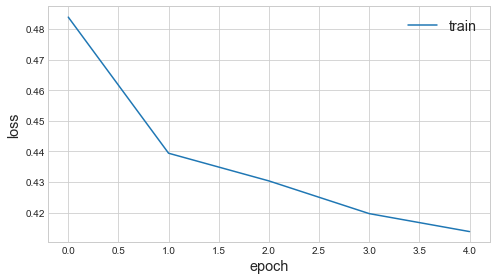

In [33]:
# Run Deep Graph Infomax

x_emb_in, x_emb_out, model = run_deep_graph_infomax(hinsage, generator, epochs=epochs)

# 2

In [24]:
# take only the accounts with testingFlag = 0 and embed them
# aka remove the first 126863 and then take the first 13769
# 15013

v_sets['Account'][-15013:].CoreCaseGraphID.value_counts()

0.0       9287
838.0        4
2100.0       4
1173.0       4
378.0        4
          ... 
844.0        1
667.0        1
362.0        1
3384.0       1
608.0        1
Name: CoreCaseGraphID, Length: 2859, dtype: int64

In [25]:
v_sets['Account'][-15013:].ExtendedCaseGraphID.value_counts()

0.0       4971
120.0       32
1027.0      31
3794.0      31
333.0       30
          ... 
3061.0       1
3575.0       1
3680.0       1
3776.0       1
2703.0       1
Name: ExtendedCaseGraphID, Length: 2425, dtype: int64

In [ ]:
alpha = 0.7


fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(
    embeddings_2d[0],
    embeddings_2d[1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal")
plt.title("TSNE visualization of HinSAGE embeddings with Deep Graph Infomax")
plt.show()

In [35]:
# Coloring based on ExtendedCaseGraphID
node_ids = G.nodes(node_type="Account").tolist()
ext_targets = v_sample.loc[[int(node_id) for node_id in node_ids]].ExtendedCaseGraphID 

label_map = {l: i*10 for i, l in enumerate(np.unique(ext_targets), start=10) if pd.notna(l)}
node_colours = [label_map[target] if pd.notna(target) else 0 for target in ext_targets]

In [ ]:
embeddings_2d = pd.DataFrame(TSNE(n_components=2).fit_transform(all_embeddings), index=G.nodes(node_type="Account"))

In [37]:
emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)
all_embeddings = emb_model.predict(
    #use a heterogeneous generator...
    generator.flow(G.nodes(node_type="Account"))
)

In [13]:
# Select only nodes of type "Account" for prediction

train_ID = train_ID[train_ID.index.isin(v_sets['Account'].index)]
test_ID = test_ID[test_ID.index.isin(v_sets['Account'].index)]